In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES = 4

env: CUDA_VISIBLE_DEVICES=4


In [2]:
# from batchflow import *
# from batchflow.named_expr
from batchflow.opensets import PascalSegmentation
from batchflow import Batch, Pipeline, B, V, C, F, apply_parallel, ImagesBatch, action
from batchflow.models.torch import *
from batchflow.models.torch.layers import *

from torch.optim import Adam
import torch
import torch.nn.functional as F
import numpy as np

from configs import unet_config

from matplotlib import pyplot as plt
plt.style.use('ggplot')

%autoreload 2

In [3]:
class PascalBatch(ImagesBatch):
    components = 'images', 'masks'
    
    def __init__(self, index, *args, **kwargs):
        super().__init__(index, *args, **kwargs)
                    
    @apply_parallel(src='images', target='for')
    def resize_min_side(self, image, size, *args, **kwargs):
        h, w = image.size
        if h > w:
            new_size = (int(h * size / w), size)
        else:
            new_size = (size, int(w * size / h))
        
        return image.resize(new_size, *args, **kwargs)
    
    @apply_parallel(src='images', target='for') 
    def normalize(self, image, mean, std):
        return (image - mean) / (std + 1e-7) 
    
    @apply_parallel(src='masks', target='for')
    def squeeze_labels(self, image):
        return image.squeeze()
    
    @apply_parallel(src='masks', target='for')
    def replace_background(self, image):
        image[image == 255] = 21.
        return image

In [4]:
dataset = PascalSegmentation(shuffle=True, batch_class=PascalBatch)

In [5]:
len(dataset.test), len(dataset.train) # make a better split

(1449, 1464)

In [6]:
batch_gen = dataset.gen_batch(1, n_iters=len(dataset))
classes = np.zeros(256, dtype=int)
for i in range(len(dataset)):
    batch = next(batch_gen)
    batch_classes, counts = np.unique(np.array(batch.masks[0], dtype=int), return_counts=True)
    classes[batch_classes] += counts
    

In [7]:
np.nonzero(classes)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20, 255]),)

In [8]:
def plot_batch_example(dataset):
    batch = dataset.p.next_batch(1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(batch.images[0])
    ax1.axis('off')
    ax2.imshow(batch.masks[0])
    ax2.axis('off')

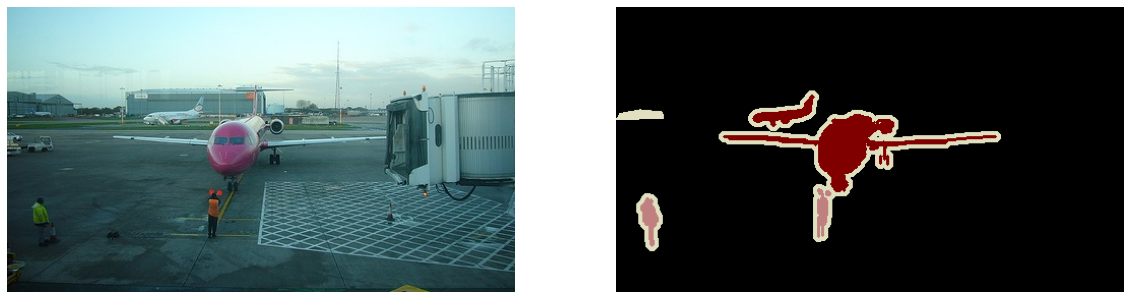

In [9]:
plot_batch_example(dataset);

In [10]:
def get_norm_stats(dataset, batch_size=64, channels='first'):
    ppl = dataset.p.to_array(src='images', dst='images')
    images = ppl.next_batch(batch_size).images
    mean = np.zeros(3)
    std = np.zeros(3)
    for i in range(batch_size):
        mean += images[i][..., 0].mean(), images[i][..., 1].mean(), images[i][..., 2].mean()
        std  += images[i][..., 0].std(), images[i][..., 1].std(), images[i][..., 2].std()
    if channels == 'first':
        mean = mean.reshape(3, 1, 1)
        std = std.reshape(3, 1, 1)
    return  mean / batch_size, std / batch_size

In [11]:
mean, std = get_norm_stats(dataset)  

preprocessing_template = (
                            Pipeline() 
                            
                            .resize_min_side(size=256, src='images', dst='images')  
                            .resize_min_side(size=256, src='masks', dst='masks')  
                            .crop(shape=(256, 256), origin='center', src='images', dst='images')
                            .crop(shape=(256, 256), origin='center', src='masks', dst='masks')
                            .to_array(src='images', dst='images', channels='first')
                            .to_array(src='masks', dst='masks', channels='first')
                            .normalize(mean=mean, std=std, src='images', dst='images')
                            .squeeze_labels(src='masks', dst='masks')
                            .replace_background(src='masks', dst='masks')
                        )

In [12]:
preprocessing_pipeline = preprocessing_template << dataset.train

In [13]:
batch = preprocessing_pipeline.next_batch(1)
print(batch.images[0].shape, batch.masks[0].shape, batch.masks[0].dtype)

(3, 256, 256) (256, 256) float32


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order)


<BarContainer object of 22 artists>

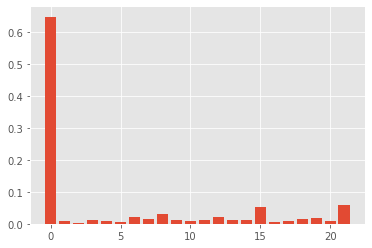

In [14]:
batch_gen = preprocessing_pipeline.gen_batch(1, n_iters=len(dataset))
classes = np.zeros(256, dtype=int)
for i in range(len(dataset)):
    batch = next(batch_gen)
    batch_classes, counts = np.unique(np.array(batch.masks[0], dtype=int), return_counts=True)
    classes[batch_classes] += counts
    
plt.bar(range(22), classes[classes > 0] / classes.sum())

In [15]:
model_config = unet_config
model_config['head']['channels'] = 22
model_config['optimizer'] = {'name': 'Adam', 'lr': 1e-4}

In [16]:
BATCH_SIZE = 32
N_ITERS = 10
BAR = True

In [17]:
train_template = (  
    preprocessing_template +
    Pipeline()
        .init_variable('loss_history', [])
        .init_model(name='model', model_class=TorchModel, config=model_config)

        .train_model('model',
                     inputs=B.images, targets=B.masks,
                     outputs='loss', save_to=V('loss_history', mode='a'))
)

In [18]:
train_pipeline = train_template << dataset.train

In [19]:
notifier = {
    'bar': 'n', 'frequency': 1,
    'graphs': ['loss_history'],
    'file': 'notifier_log.txt',
    'savepath': None
}

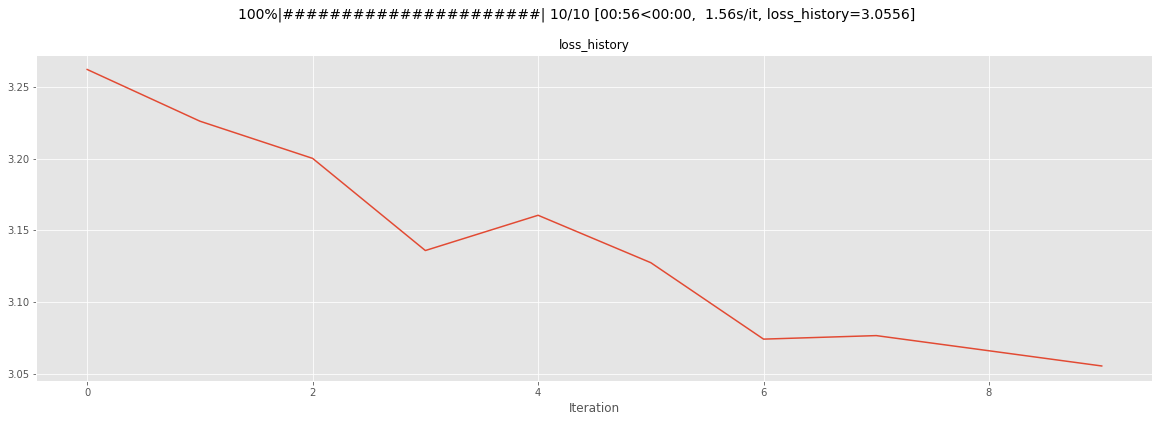

In [20]:
train_pipeline.run(batch_size=BATCH_SIZE, n_iters=N_ITERS, notifier=notifier)

In [21]:
validation_template = (
    preprocessing_template +
    Pipeline()
    .init_model(name='model', source=train_pipeline)
    .init_variable('metrics')
    .init_variable('inferred_masks')
    .init_variable('val_loss', [])
    .init_variable('mean_val_loss', 0)
    .init_variable('train_loss', train_pipeline.get_variable('loss_history'))
    
    .predict_model('model',
                   inputs=B.images,
                   targets=B.masks,
                   outputs= ['predictions', 'loss'],
                   save_to=[V('inferred_masks', mode='a'), V('val_loss', mode='a')]) # change loss mode
    # .update(V('mean_loss_var'), np.mean)
    .gather_metrics('segmentation', # background class ???
                    targets=B.masks,
                    predictions=V('inferred_masks'),
                    fmt='logits',
                    axis=1,
                    save_to=V('metrics', mode='u')
                   )
)

In [22]:
(validation_template << dataset.test).run(batch_size=1, n_iters=1)